<a href="https://colab.research.google.com/github/obbcopper/Python-programs-in-Data-Science/blob/main/cnnMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,  Dropout, Dense, Flatten
from tensorflow.keras.optimizers import SGD
import timeit

dataset mnist from https://www.kaggle.com/competitions/digit-recognizer/data

In [ ]:
df_train = pd.read_csv('gdrive/MyDrive/train.csv')
df_test = pd.read_csv('gdrive/MyDrive/test.csv')
df_test_sample_submission = pd.read_csv('gdrive/MyDrive/sample_submission.csv')

**Usage the function below**

1.   **data_preprocessing_train** : seperate the label for
df_train, reshape the trainX into from 784 x 64000 to 28 x 28 x 1 x 64000 and normalize the value in trainX

     same as data_preprocessing_test, just without first step
2.   **show_data** : data visualization

3.   **split** split the data into training dataset and the validation dataset, with a ratio of 9:1

In [ ]:
def data_preprocessing_train(df_train):
    trainX = df_train.iloc[:, 1:].to_numpy()
    trainY = df_train.iloc[:, [0]].to_numpy()
    # print('Train data before reshape: X=%s, y=%s' % (trainX.shape, trainY.shape))

    trainX = trainX.reshape(-1, 28, 28, 1)
    trainY = to_categorical(trainY)
    # print('Train data after reshape: X=%s, y=%s' % (trainX.shape, trainY.shape))

    # show_data(trainX)
    trainX = normalize(trainX)

    return trainX, trainY

def data_preprocessing_test(df_test):
    testX = df_test.to_numpy()
    testX = testX.reshape(-1, 28, 28, 1)
    testX = normalize(testX)

    return testX

def normalize(data):
    data_norm = data.astype('float32')
    data_norm = data / 255.0
    return data_norm

def split(trainX, trainY):
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1, random_state=114514)
    return trainX, valX, trainY, valY

def show_data(data):
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(data[i], cmap=plt.get_cmap('gray'))
    plt.show()

**Dimension Changes**

Since we use padding='same' in all the conv layes, the dimension of the data only change in max pooling section.
```
Input (28x28x1)
  → Conv2D → (28x28x32)
  → Conv2D → (28x28x32)
  → MaxPool → (14x14x32)
  → Dropout → (14x14x32)
  → Conv2D → (14x14x32)
  → Conv2D → (14x14x32)
  → MaxPool → (7x7x32)
  → Flatten → (1568)
  → Dense → (100)
  → Dense → (10)
```



In [ ]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.tight_layout()

This code visualize 9 misclassified images from the validation set

In [ ]:
def plot_misclassified(model, valX, valY, num_samples=9):
    # Get predictions and convert to class labels
    y_pred = np.argmax(model.predict(valX), axis=1)

    # Convert one-hot encoded validation labels to integers
    y_true = np.argmax(valY, axis=1)

    # Find misclassified indices
    misclassified = np.where(y_pred != y_true)[0]

    # If no misclassified samples found
    if len(misclassified) == 0:
        print("Perfect predictions! No misclassified samples.")
        return

    # Select random misclassified samples (up to num_samples)
    display_indices = np.random.choice(misclassified, min(num_samples, len(misclassified)), replace=False)

    # Plot settings
    plt.figure(figsize=(6, 6))
    plt.suptitle("Misclassified Samples", fontsize=16)

    # Plot images
    for i, idx in enumerate(display_indices):
        plt.subplot(330 + 1 + i)

        # Remove channel dimension for plotting (from (28,28,1) to (28,28))
        image = valX[idx].squeeze()

        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {y_pred[idx]}\nTrue: {y_true[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**In order to accelerate the process of training, batch_size is set to 42,000*0.9/40**

We compute the executing time of fitting cnn model using timeit.default_timer

The hyperparameter epochs and batch_size are optimize by trial and error

In [ ]:
def cnn_fit(train_dataframe):

  trainX, trainY = data_preprocessing_train(train_dataframe)
  trainX, valX, trainY, valY = split(trainX, trainY)
  cnn = define_model()

  start_time = timeit.default_timer()

  history = cnn.fit(trainX, trainY, epochs=5, batch_size=945, validation_data=(valX, valY), verbose=1)
  plot_misclassified(cnn, valX, valY)
  summarize_diagnostics(history)

  end_time = timeit.default_timer()
  print(f"Execution time: {end_time - start_time:.2f} seconds")

  return cnn

**We use np.argmax to the prediction, change the probability distrubution into prediction**

In [ ]:
def cnn_predict(test_dataframe, decision_tree):

  test_dataframe = data_preprocessing_test(test_dataframe)
  prediction = decision_tree.predict(test_dataframe)
  prediction = np.argmax(prediction, axis=1)
  print("The prediction is finished")

  return prediction

In [ ]:
def write_prediction_to_csv(submission_format, prediction, csv_file_name):

  prediction = submission_format["Label"] = prediction
  submission_format.to_csv(csv_file_name, index=False)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.4859 - loss: 1.5608 - val_accuracy: 0.9298 - val_loss: 0.2440
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9326 - loss: 0.2237 - val_accuracy: 0.9588 - val_loss: 0.1454
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9588 - loss: 0.1358 - val_accuracy: 0.9679 - val_loss: 0.1129
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9692 - loss: 0.1014 - val_accuracy: 0.9769 - val_loss: 0.0882
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9741 - loss: 0.0837 - val_accuracy: 0.9783 - val_loss: 0.0800
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


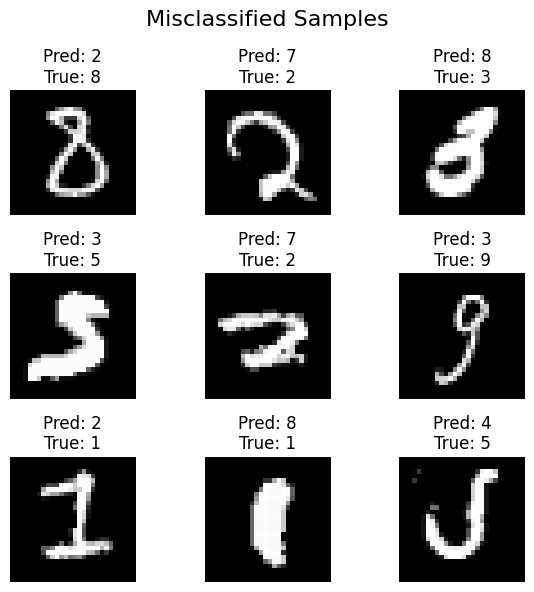

Execution time: 716.94 seconds
875/875 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step
The prediction is finished


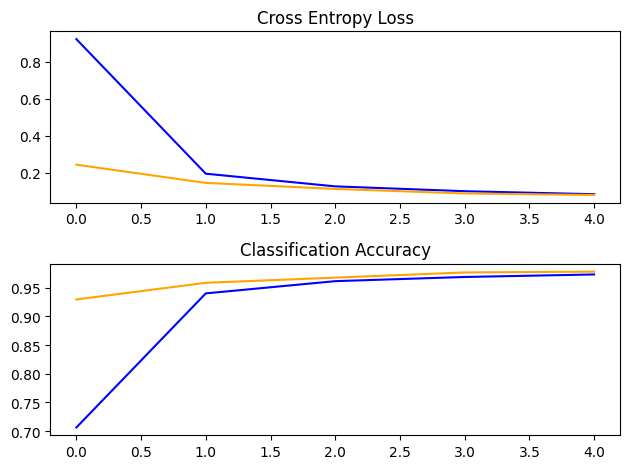

In [ ]:
cnn = cnn_fit(df_train)
prediction_cnn = cnn_predict(df_test, cnn)
write_prediction_to_csv(df_test_sample_submission, prediction_cnn, 'prediction_cnn.csv')

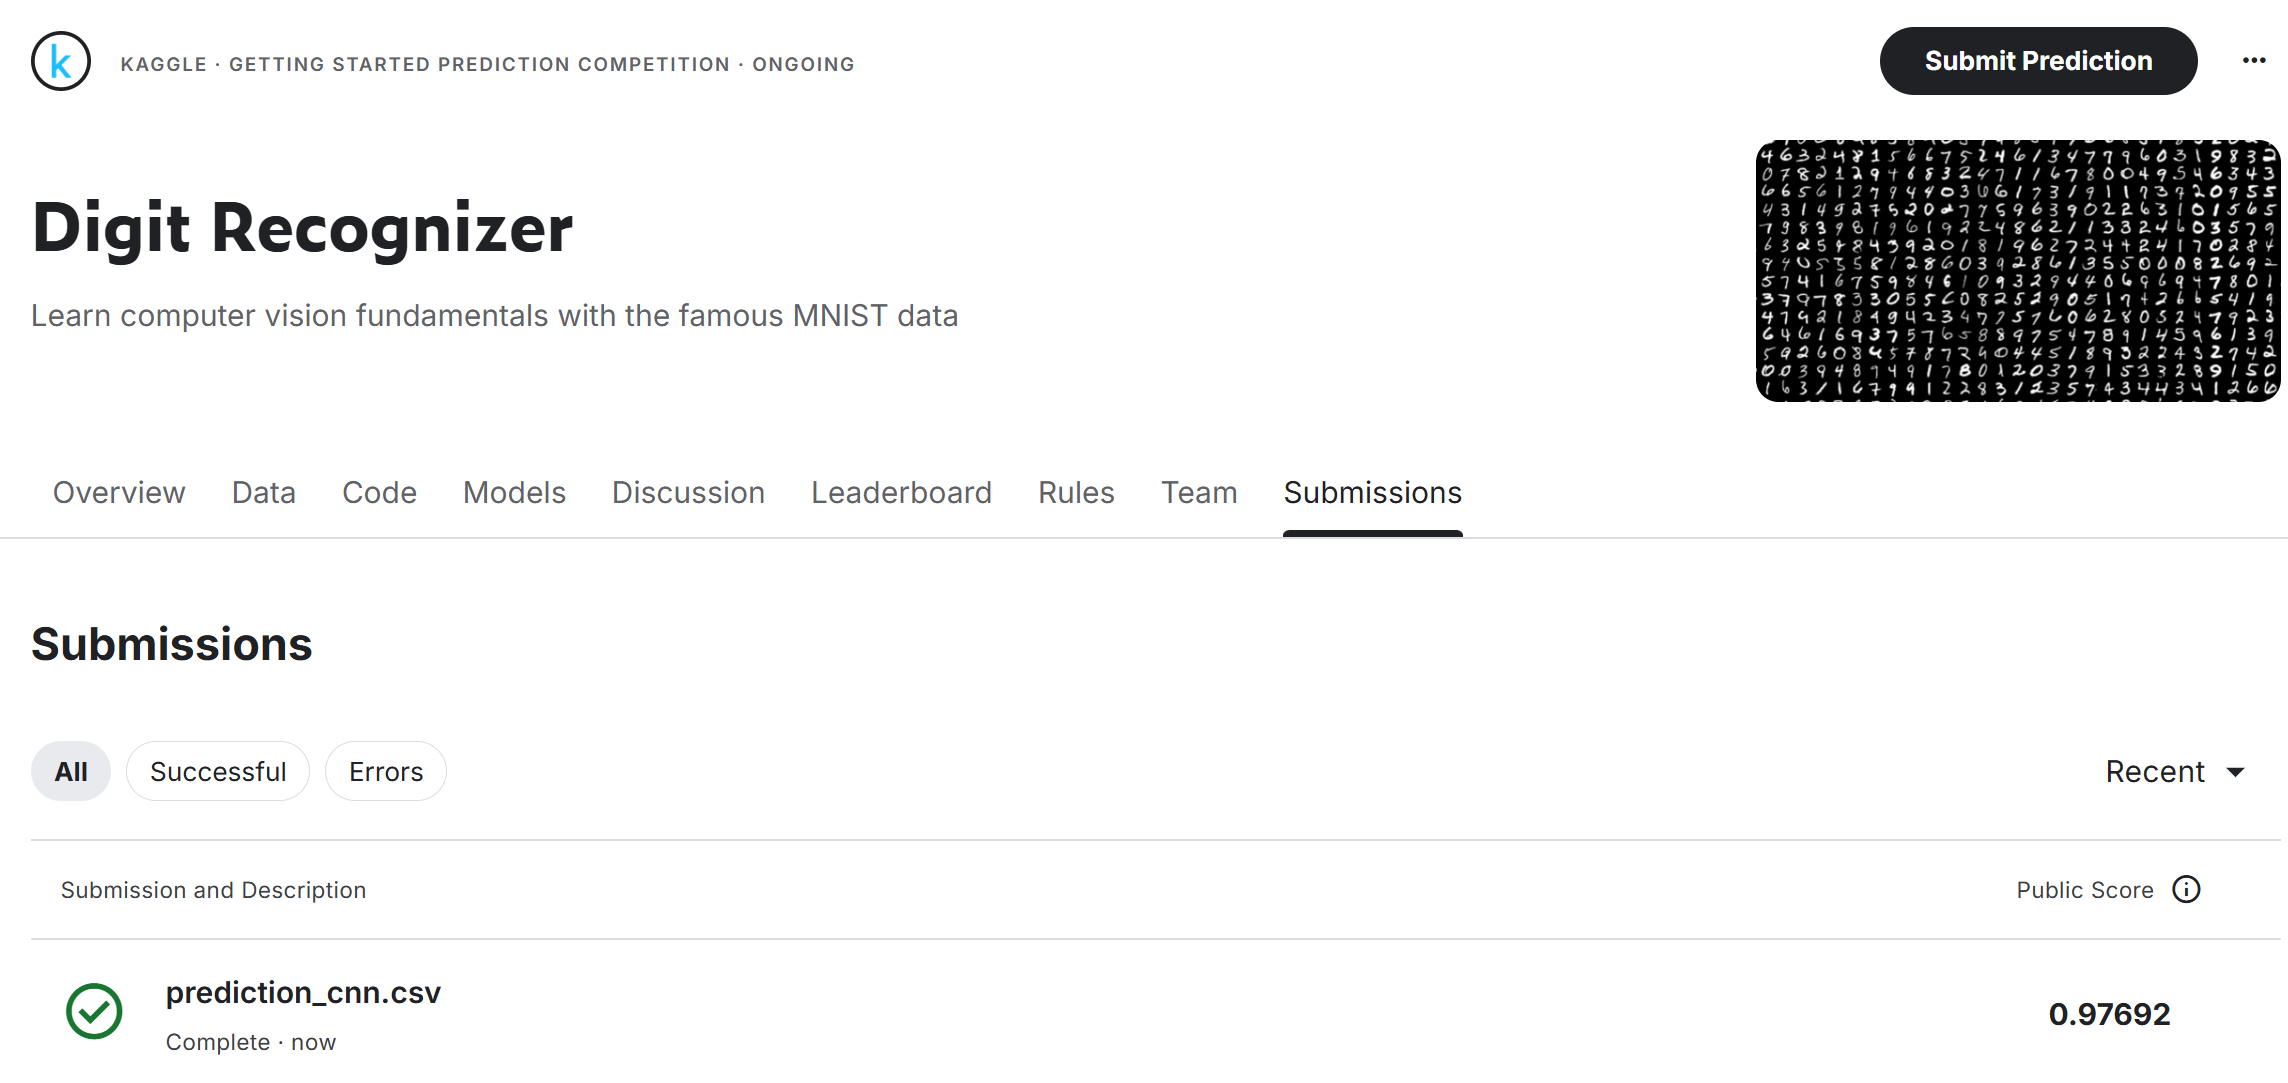

In [ ]:
from IPython.display import Image
Image(filename='gdrive/MyDrive/my_score.png', width=1000)